# GenAI Carrer Adviser

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#LLM

In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b", temperature=0.4)

#WorkFlow State

In [9]:
from typing_extensions import TypedDict

class State(TypedDict):
    query: str 
    category: str 
    response: str 

#Helper Functions

In [10]:
from langchain_core.messages import trim_messages
from datetime import datetime

def message_trimmer(messages, max_messages: int = 10):
    """Trim conversation history to retain only the last messages within provided limit"""
    return trim_messages(
        messages,
        max_tokens = max_messages,
        strategy = "last",
        token_counter = len,
        start_on = "human",
        allow_partial = False,
        include_system = True,
    )

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "Agent_output"  # Folder to store output files
    os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
    
    # Generate a timestamped filename for uniqueness
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")  # Format: YYYYMMDDHHMMSS
    filename = f"{filename}_{timestamp}.md"
    
    # Define the full file path
    file_path = os.path.join(folder_name, filename)
    
    # Save the data to the file in the specified path
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")
    
    # Return the full path of the saved file
    return file_path

def show_md_file(file_path):
    """Displays the content of a markdown file as Markdown in the notebook."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Render the content in Markdown format within the notebook
    display(Markdown(content))

#Learning Resource Class

In [11]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.messages import HumanMessage, AIMessage

class LearningResouceAgent:
    def __init__(self, prompt):
        self.llm = llm
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def TutorialAgent(self, user_input):
        """cretes an agent and provides response by invoking it"""
        agent = create_tool_calling_agent(self.llm, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent= agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"query": user_input})

        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path
        
    def QueryBot(self, user_input):
        """Interactive q&a bot"""
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.append('User Query: %s \n' % user_input)
        self.prompt.append(HumanMessage(content=user_input))
        while True:
            self.prompt = message_trimmer(self.prompt)
            response = self.llm.invoke(self.prompt)
            record_QA_session.append('\nExpert Response: %s \n' % response.content)

            self.prompt.append(AIMessage(content=response.content))
            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\nEXPERT AGENT RESPONSE:", response.content)

            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\nYOUR QUERY: ")
            record_QA_session.append('\nUser Query: %s \n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))

            if user_input.lower() == "exit":
                print("Ending the chat session.")

#Interview Prep Agent

In [12]:
class InterviewAgent:
    def __init__(self, prompt):
        self.llm = llm
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]

    def Interview_questions(self, user_input):
        chat_history = []
        questions_bank = ''
        self.agent = create_tool_calling_agent(self.llm, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break 
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"

            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]

            user_input = input("You: ")

        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interviews question saved to {path}")
        return path
    
    def Mock_Interview(self):
        print("\nStarting the mock interview. Type 'exit' to end the session.\n")
        
        initial_message = 'I am ready for the interview.\n'
        interview_record = []
        interview_record.append('Candidate: %s \n' % initial_message)
        self.prompt.append(HumanMessage(content=initial_message))

        while True:
            self.prompt = message_trimmer(self.prompt)
            response = self.llm.invoke(self.prompt)
            self.prompt.append(AIMessage(content=response.content))
            print("\nInterviewer:", response.content)
            interview_record.append('\nInterviewer: %s \n' % response.content)

            user_input = input("\nCandidate: ")
            interview_record.append('\nCandidate: %s \n' % user_input)
            self.prompt.append(HumanMessage(content=user_input))
            
            if user_input.lower() == "exit":
                print("Ending the interview session.")
                path = save_file(''.join(interview_record),'Mock_Interview')
                print(f"Mock Interview saved to {path}")
                return path

#Resume Maker Class

In [13]:
class ResumeMaker:
    def __init__(self, prompt):
        self.model = llm
        self.prompt = prompt
        self.tools = [DuckDuckGoSearchResults()]
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])

            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            user_input = input("You: ")
        
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path

#Job Search Class

In [14]:
class JobSearch:
    def __init__(self, prompt):
        self.model = llm
        self.prompt = prompt
        self.tools = DuckDuckGoSearchResults()

    def find_jobs(self, user_input):
        results = self.tools.invoke(user_input)
        chain = self.prompt | self.model  
        jobs = chain.invoke({"result": results}).content
        
        path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
        print(f"Jobs saved to {path}")
        return path

#Categorization Function

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def categorize(state: State) -> State:
    """Categorizes the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n"
        "4. Query: 'Are there any job openings for AI engineers?' -> 4\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )
    chain = prompt | llm 
    print('Categorizing the customer query...')
    category = chain.invoke({"query": state["query"]}).content
    #state.category = category
    return {"category": category}

In [16]:
def handle_learning_resource(state: State) -> State:
    """Determines if the query is related to Tutorial creation or general Questions on generative AI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

In [17]:
def handle_interview_preparation(state: State) -> State:
    """Determines if the query is related to Mock Interviews or general Interview Questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

In [18]:
def job_search(state: State) -> State:
    """Provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''Your task is to refactor and make .md file for the this content which includes
    the jobs available in the market. Refactor such that user can refer easily. Content: {result}''')
    jobSearch = JobSearch(prompt)
    state["query"] = input('Please make sure to mention Job location you want,Job roles\n')
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

In [19]:
def handle_resume_making(state: State) -> State:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''),
       MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response": path}

In [20]:
from langchain_core.messages import SystemMessage 

def ask_query_bot(state: State) -> State:
    """Provide detailed answers to user queries related to Generative AI."""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content=system_message)]

    learning_agent = LearningResouceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response": path}

In [21]:
def tutorial_agent(state: State) -> State:
    """Generate a tutorial blog for Generative AI based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    prompt = ChatPromptTemplate.from_messages([("system", system_message),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])
    learning_agent = LearningResouceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

In [22]:
def interview_topics_questions(state: State) -> State:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

In [24]:
def mock_interview(state: State) -> State:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

In [25]:
def route_query(state: State):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state["category"]:
        print('Category: handle_learning_resource')
        return "handle_learning_resource" 
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"  
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"  
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search" 
    else:
        print("Please ask your question based on my description.")
        return False

In [26]:
def route_interview(state: State) -> str:
    """Route the query to the appropriate interview-related handler."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"  
    elif 'Mock'.lower() in state["category"].lower():
        print('Category: mock_interview')
        return "mock_interview"  
    else:
        print('Category: mock_interview')
        return "mock_interview"

In [27]:
def route_learning(state: State):
    """Route the query based on the learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: ask_query_bot')
        return "ask_query_bot" 
    elif 'Tutorial'.lower() in state["category"].lower():
        print('Category: tutorial_agent')
        return "tutorial_agent"  
    else:
        print("Please ask your question based on my interview description.")
        return False

#WorkFlow

In [28]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node("categorize", categorize)  
workflow.add_node("handle_learning_resource", handle_learning_resource) 
workflow.add_node("handle_resume_making", handle_resume_making)  
workflow.add_node("handle_interview_preparation", handle_interview_preparation)  
workflow.add_node("job_search", job_search)  
workflow.add_node("mock_interview", mock_interview)  
workflow.add_node("interview_topics_questions", interview_topics_questions) 
workflow.add_node("tutorial_agent", tutorial_agent)  
workflow.add_node("ask_query_bot", ask_query_bot)  

workflow.add_edge(START, "categorize")

workflow.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search"
    }
)

workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,
    {
        "mock_interview": "mock_interview",
        "interview_topics_questions": "interview_topics_questions",
    }
)

workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,
    {
        "tutorial_agent": "tutorial_agent",
        "ask_query_bot": "ask_query_bot",
    }
)

workflow.add_edge("handle_resume_making", END)
workflow.add_edge("job_search", END)
workflow.add_edge("interview_topics_questions", END)
workflow.add_edge("mock_interview", END)
workflow.add_edge("ask_query_bot", END)
workflow.add_edge("tutorial_agent", END)

workflow.set_entry_point("categorize")

app = workflow.compile()

#Graph Image

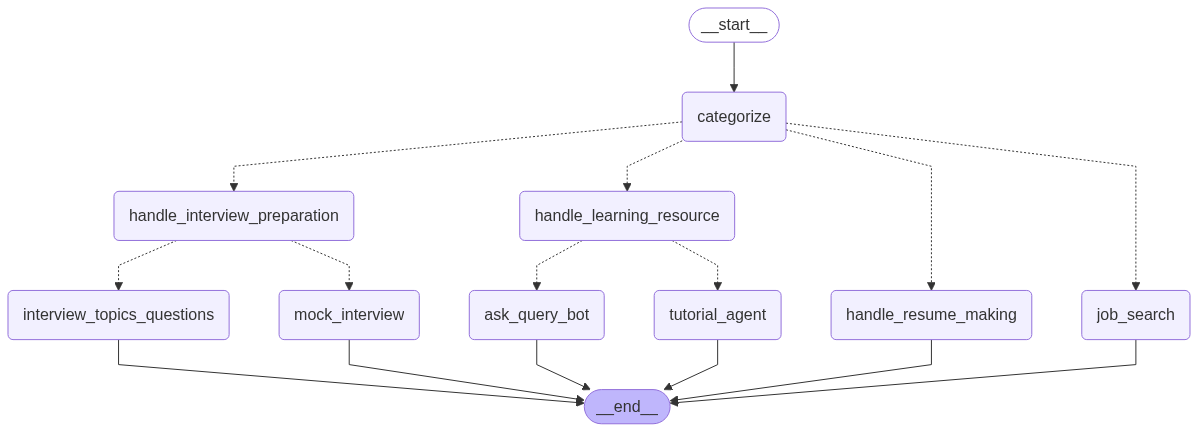

In [30]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [31]:
from typing_extensions import Dict

def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "response": results["response"]
    }

#TestCase

In [1]:
query = "can you prepare a resume for genai role?"
result = run_user_query(query)
print(result)

NameError: name 'run_user_query' is not defined